# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [8]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             rotate=False, reflect_x=False, reflect_y=True, reflect_z=True,
                             input_pipe=input_pipe, rot_mult=0)

Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


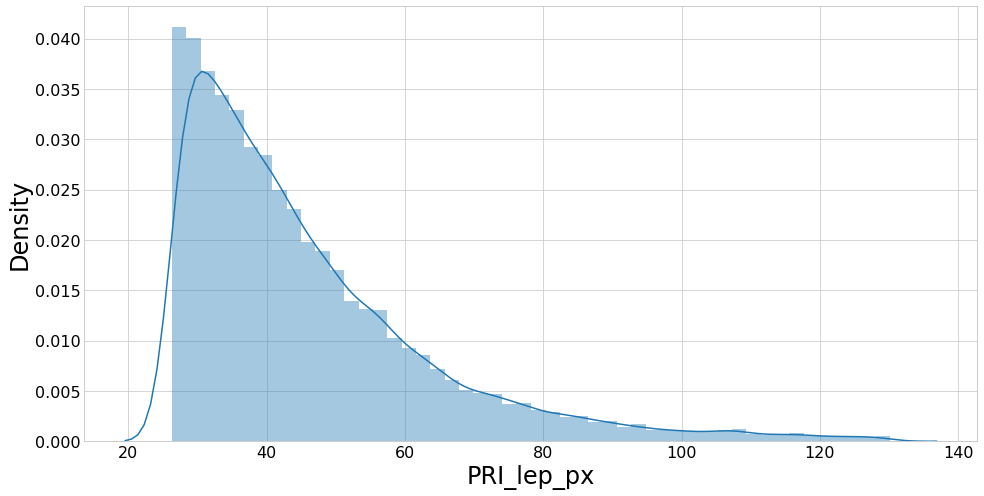

In [13]:
data = pd.DataFrame(input_pipe.inverse_transform(np.array(train_fy.source['fold_0/inputs'])), columns=train_feats)
plot_feat(data, 'PRI_lep_px')

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 17.615s 


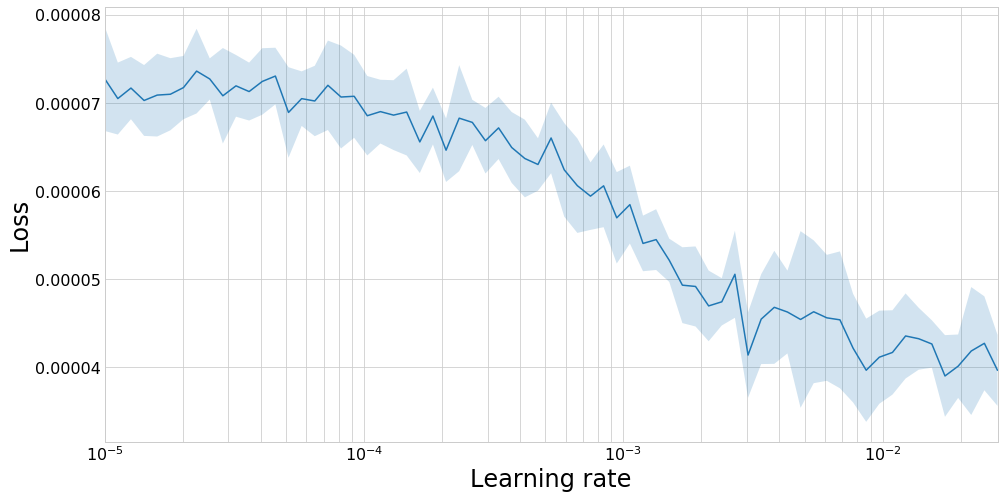

______________________________________



In [14]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [15]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192162). Check your callbacks.
  % delta_t_median)


1 New best found: 3.834403975568272e-05
2 New best found: 3.7158252744437066e-05
3 New best found: 3.570719690843344e-05
4 New best found: 3.494347141109444e-05
5 New best found: 3.480661975714368e-05
6 New best found: 3.420911527882822e-05
7 New best found: 3.4163697560357626e-05
11 New best found: 3.37581815485985e-05
12 New best found: 3.3481785500884e-05
14 New best found: 3.343759279432935e-05
15 New best found: 3.339303586650303e-05
24 New best found: 3.333424539352624e-05
25 New best found: 3.327430318337321e-05
27 New best found: 3.313204540541734e-05
29 New best found: 3.304022788382748e-05
30 New best found: 3.298952632402634e-05
42 New best found: 3.2958128013841855e-05
48 New best found: 3.295141887120738e-05
51 New best found: 3.270623956517296e-05
56 New best found: 3.270575906528336e-05
57 New best found: 3.264790414478874e-05
60 New best found: 3.2637630469262334e-05
61 New best found: 3.261433412688369e-05
96 New best found: 3.2604881077707756e-05
104 New best found: 3

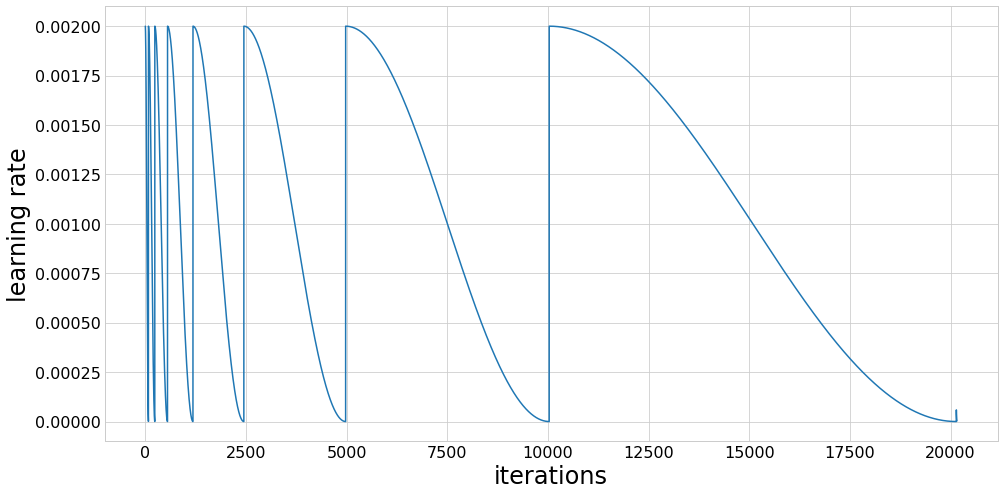

Fold took 276.231s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252786). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126781). Check your callbacks.
  % delta_t_median)


1 New best found: 3.959429877777894e-05
2 New best found: 3.592026486815506e-05
3 New best found: 3.560007644477988e-05
4 New best found: 3.540207577743946e-05
5 New best found: 3.457514360893901e-05
6 New best found: 3.405392776205436e-05
7 New best found: 3.3879353500328075e-05
9 New best found: 3.373025349847333e-05
10 New best found: 3.349213225888627e-05
12 New best found: 3.3190109149884964e-05
13 New best found: 3.2929160943451724e-05
14 New best found: 3.285176661491341e-05
15 New best found: 3.2850128393095376e-05
20 New best found: 3.278786199600679e-05
22 New best found: 3.276624336551418e-05
25 New best found: 3.271189292315123e-05
26 New best found: 3.247135701755676e-05
28 New best found: 3.24006255328404e-05
29 New best found: 3.23456424079752e-05
30 New best found: 3.2343753984578506e-05
31 New best found: 3.233945018007449e-05
48 New best found: 3.225610796999809e-05
49 New best found: 3.223668894514339e-05
53 New best found: 3.2147115028520904e-05
56 New best found: 3

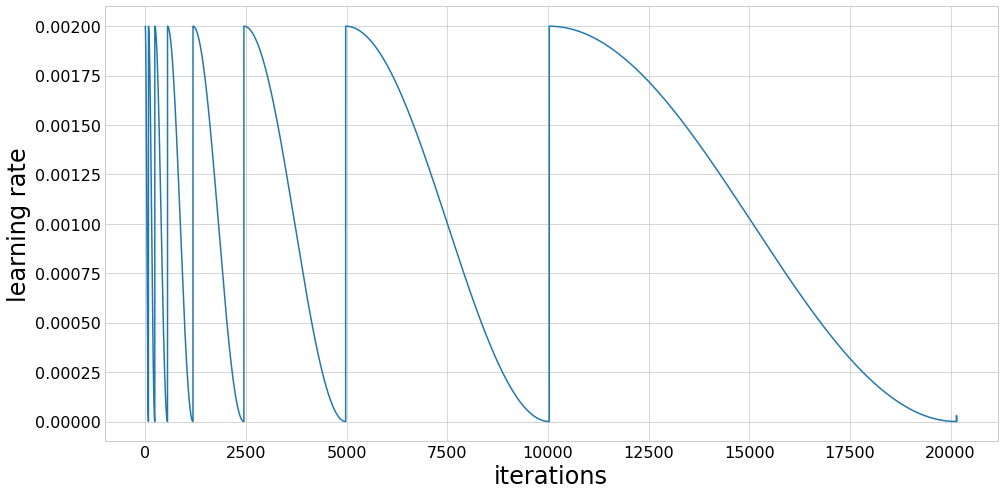

Fold took 279.694s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.276754). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138777). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7200806305877266e-05
2 New best found: 3.408460351101387e-05
3 New best found: 3.357863289262742e-05
4 New best found: 3.306822836982986e-05
5 New best found: 3.2860144465345455e-05
6 New best found: 3.2200547993531456e-05
7 New best found: 3.2092088075023556e-05
10 New best found: 3.202270449046137e-05
11 New best found: 3.180514277693448e-05
12 New best found: 3.164204007211928e-05
13 New best found: 3.1243076790370583e-05
23 New best found: 3.1100005372606166e-05
24 New best found: 3.09205537190042e-05
25 New best found: 3.091947576490967e-05
27 New best found: 3.082074700695152e-05
28 New best found: 3.0737674047578645e-05
31 New best found: 3.073586744838618e-05
46 New best found: 3.065899013400432e-05
47 New best found: 3.049921743141585e-05
53 New best found: 3.047065717555008e-05
54 New best found: 3.044977606063375e-05
56 New best found: 3.040375084563415e-05
58 New best found: 3.038767217135016e-05
59 New best found: 3.0384725671464484e-05
60 New best foun

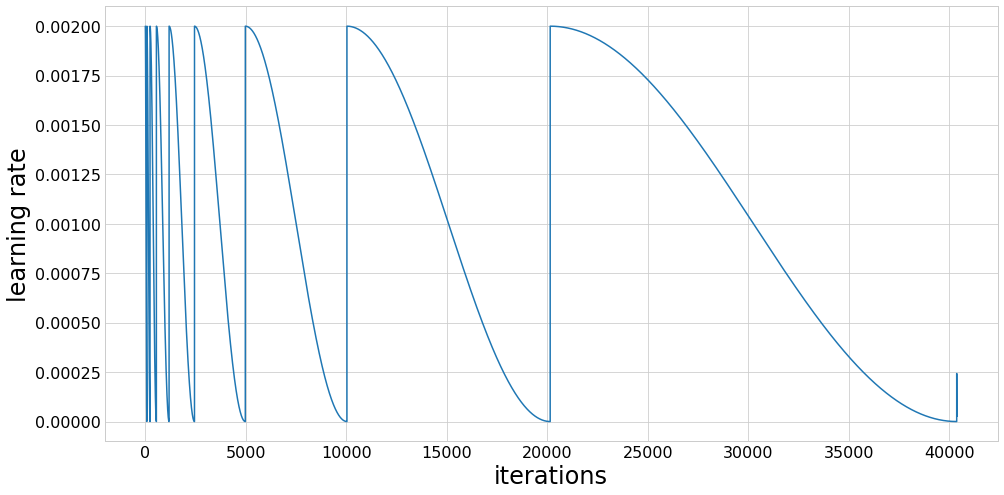

Fold took 546.970s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.345426). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173109). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9053956830018924e-05
2 New best found: 3.538234251593557e-05
3 New best found: 3.496989034940447e-05
4 New best found: 3.440351029417549e-05
5 New best found: 3.370200752331578e-05
6 New best found: 3.3247873913906365e-05
7 New best found: 3.316794224496197e-05
10 New best found: 3.309658994963959e-05
11 New best found: 3.280747521379053e-05
12 New best found: 3.258518660471156e-05
13 New best found: 3.2451205595384065e-05
14 New best found: 3.2411436888532674e-05
15 New best found: 3.2383358977307716e-05
23 New best found: 3.225844350298641e-05
24 New best found: 3.221030230187511e-05
26 New best found: 3.210816041146386e-05
27 New best found: 3.200264122281083e-05
29 New best found: 3.192584898464769e-05
30 New best found: 3.191802696782535e-05
31 New best found: 3.190816657555975e-05
50 New best found: 3.184512121342495e-05
51 New best found: 3.1661618015338626e-05
53 New best found: 3.159851470702093e-05
54 New best found: 3.159115709214312e-05
55 New best found

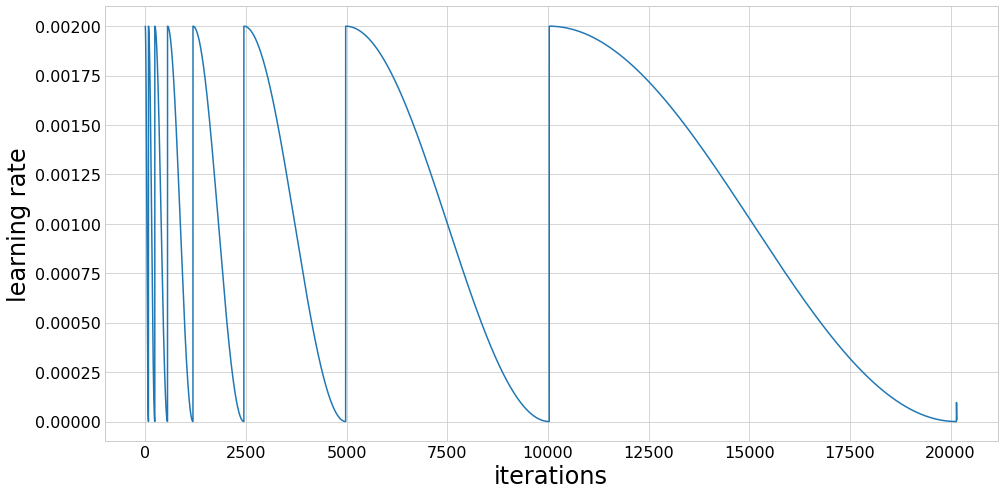

Fold took 287.527s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.330372). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165565). Check your callbacks.
  % delta_t_median)


1 New best found: 3.788385681837099e-05
2 New best found: 3.531375862658024e-05
3 New best found: 3.462942537735216e-05
4 New best found: 3.4482326806755736e-05
5 New best found: 3.3557922215550206e-05
6 New best found: 3.311332942685113e-05
7 New best found: 3.2955067958391734e-05
10 New best found: 3.281256670452421e-05
11 New best found: 3.271399374352768e-05
13 New best found: 3.234268402593443e-05
14 New best found: 3.223775547376135e-05
15 New best found: 3.2188031803525516e-05
24 New best found: 3.2144087809138e-05
25 New best found: 3.1939183607755695e-05
26 New best found: 3.192970381642226e-05
27 New best found: 3.184999201766914e-05
28 New best found: 3.1785660244349856e-05
29 New best found: 3.1750553287565706e-05
30 New best found: 3.174685320991557e-05
31 New best found: 3.17372969337157e-05
50 New best found: 3.159291921328986e-05
55 New best found: 3.151800618506968e-05
56 New best found: 3.150487682869425e-05
58 New best found: 3.147166097041918e-05
59 New best found: 

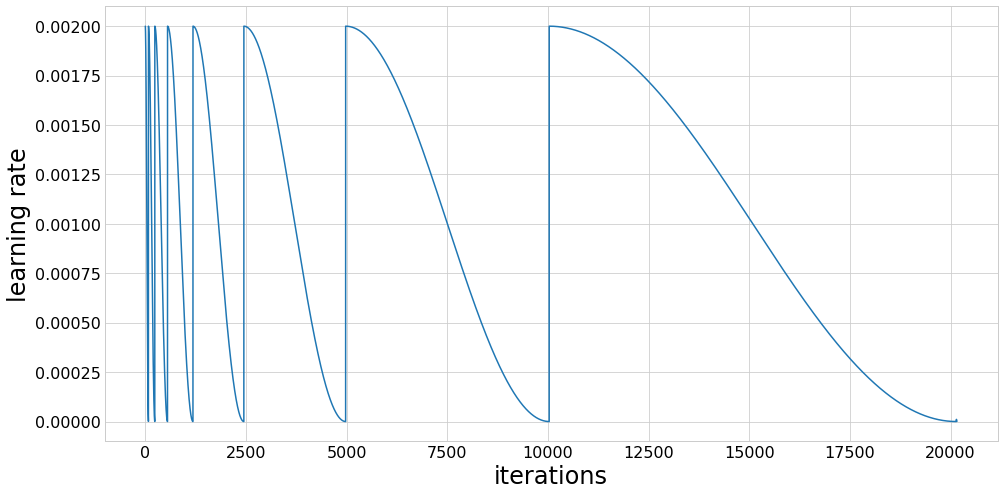

Fold took 291.053s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.368141). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184423). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8890455039178845e-05
2 New best found: 3.596196228794489e-05
3 New best found: 3.5153171727008265e-05
4 New best found: 3.498843099459504e-05
5 New best found: 3.437389637391396e-05
6 New best found: 3.396728080699239e-05
7 New best found: 3.387615248810138e-05
10 New best found: 3.374751758093362e-05
11 New best found: 3.3316694647416876e-05
12 New best found: 3.3191234760745784e-05
13 New best found: 3.311728584640038e-05
14 New best found: 3.3084362102588416e-05
15 New best found: 3.3052801402588545e-05
20 New best found: 3.293826450803307e-05
21 New best found: 3.283436275938154e-05
25 New best found: 3.2801399609225416e-05
27 New best found: 3.2605110011316704e-05
28 New best found: 3.251511127217908e-05
29 New best found: 3.245651463606171e-05
30 New best found: 3.24425442446565e-05
31 New best found: 3.243917816350182e-05
51 New best found: 3.232955322598603e-05
52 New best found: 3.227000803882426e-05
54 New best found: 3.224299286944987e-05
55 New best foun

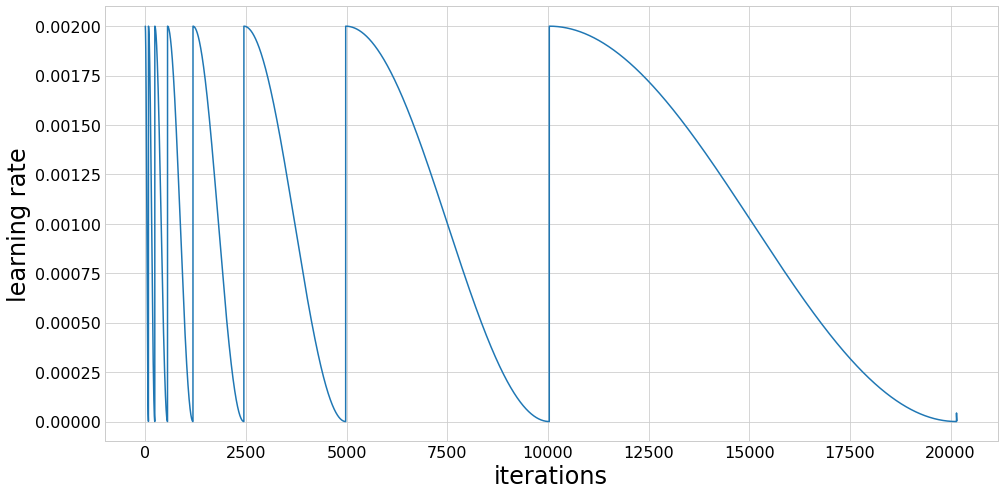

Fold took 289.500s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.408391). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204624). Check your callbacks.
  % delta_t_median)


1 New best found: 3.819579167029588e-05
2 New best found: 3.481978679919848e-05
3 New best found: 3.4490701917093246e-05
5 New best found: 3.4301841659180355e-05
6 New best found: 3.318779161345447e-05
7 New best found: 3.3076183285447766e-05
11 New best found: 3.294775490576285e-05
12 New best found: 3.264274210087024e-05
13 New best found: 3.2432187108497604e-05
24 New best found: 3.2312860625097526e-05
25 New best found: 3.223202063236386e-05
27 New best found: 3.205999632627936e-05
28 New best found: 3.1973994735744784e-05
29 New best found: 3.19715566598461e-05
30 New best found: 3.194192428927636e-05
31 New best found: 3.19396423350554e-05
46 New best found: 3.189892174850684e-05
51 New best found: 3.173989278002409e-05
55 New best found: 3.163731546810595e-05
58 New best found: 3.162877162540099e-05
60 New best found: 3.162174040044192e-05
61 New best found: 3.160228161577834e-05
62 New best found: 3.160128680610796e-05
100 New best found: 3.152431902781245e-05
108 New best foun

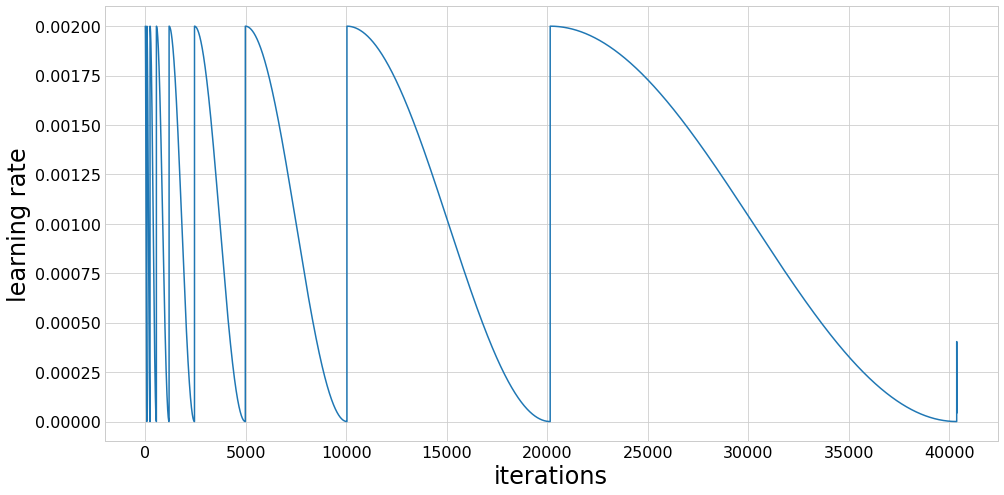

Fold took 565.123s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.407708). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204362). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9047469379147516e-05
2 New best found: 3.5883906020899305e-05
3 New best found: 3.511459898290923e-05
5 New best found: 3.4139655738545114e-05
6 New best found: 3.3794630320335276e-05
7 New best found: 3.366884303541156e-05
10 New best found: 3.360537980333902e-05
12 New best found: 3.324903758621076e-05
13 New best found: 3.307270955847344e-05
20 New best found: 3.303117624527658e-05
21 New best found: 3.300060441179085e-05
24 New best found: 3.2879621358733856e-05
25 New best found: 3.286371384456288e-05
26 New best found: 3.276605247665429e-05
27 New best found: 3.26814819338324e-05
28 New best found: 3.258737382348045e-05
29 New best found: 3.2523333499557336e-05
30 New best found: 3.245236515067518e-05
31 New best found: 3.245127104164567e-05
53 New best found: 3.239854855346494e-05
55 New best found: 3.235534529594588e-05
56 New best found: 3.234283175479504e-05
57 New best found: 3.2292128973494985e-05
58 New best found: 3.228723956563045e-05
62 New best foun

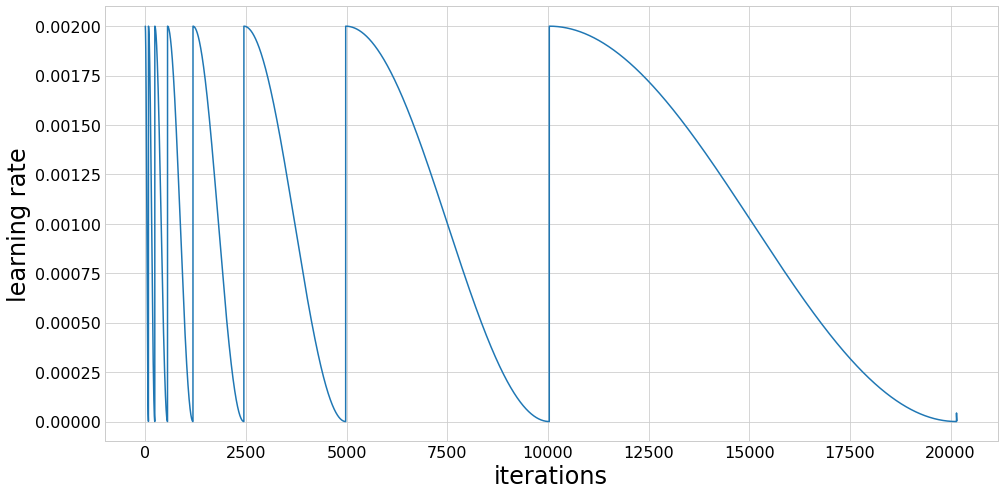

Fold took 296.493s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.449239). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225019). Check your callbacks.
  % delta_t_median)


1 New best found: 3.832151786627946e-05
2 New best found: 3.537146647431655e-05
3 New best found: 3.4790054647601207e-05
4 New best found: 3.433180149295367e-05
5 New best found: 3.383641947002616e-05
6 New best found: 3.319158242084086e-05
7 New best found: 3.3078618478612045e-05
11 New best found: 3.2952239830046893e-05
12 New best found: 3.2595875739934856e-05
13 New best found: 3.248956702009309e-05
14 New best found: 3.2363210573385004e-05
15 New best found: 3.234108940960141e-05
21 New best found: 3.219916488742456e-05
26 New best found: 3.2096668088342995e-05
27 New best found: 3.193734282103833e-05
30 New best found: 3.1922372794360855e-05
48 New best found: 3.1912527626991504e-05
51 New best found: 3.186630695563508e-05
52 New best found: 3.1762701831758025e-05
54 New best found: 3.1743495856062506e-05
56 New best found: 3.163396923991968e-05
60 New best found: 3.157387192768511e-05
61 New best found: 3.156764626619406e-05
95 New best found: 3.151455803235876e-05
96 New best f

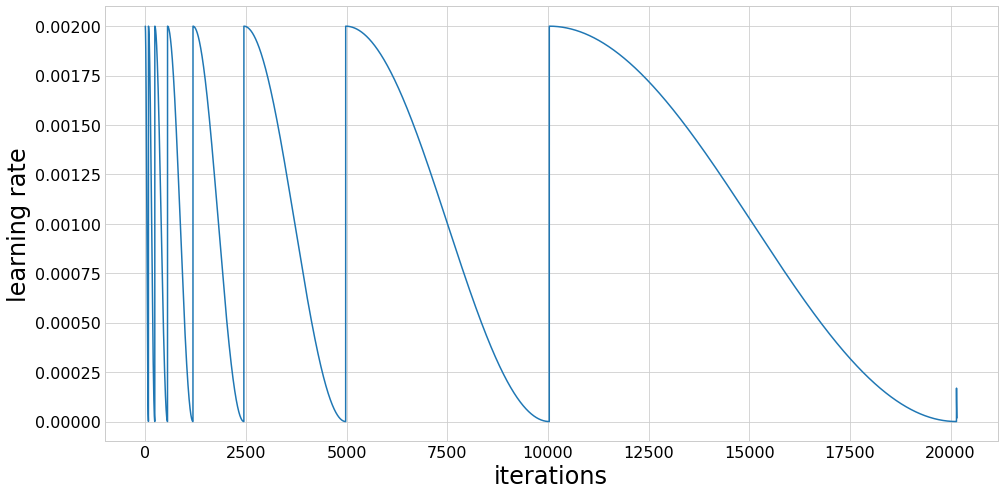

Fold took 299.741s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.460474). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230694). Check your callbacks.
  % delta_t_median)


1 New best found: 3.871757728931829e-05
2 New best found: 3.5880304627432724e-05
3 New best found: 3.5302258949204834e-05
5 New best found: 3.497214285251696e-05
6 New best found: 3.426578550723207e-05
7 New best found: 3.403070443815664e-05
11 New best found: 3.375233508927046e-05
12 New best found: 3.360288625982182e-05
13 New best found: 3.3366469200376e-05
14 New best found: 3.33286633924644e-05
22 New best found: 3.3225113204130234e-05
25 New best found: 3.310893094124154e-05
27 New best found: 3.300901613052051e-05
28 New best found: 3.2941959211584384e-05
30 New best found: 3.2935902779812646e-05
31 New best found: 3.293306837666107e-05
46 New best found: 3.2903088535678524e-05
50 New best found: 3.2714783474185884e-05
52 New best found: 3.2700808410985955e-05
53 New best found: 3.2696945576565405e-05
56 New best found: 3.262463253580904e-05
57 New best found: 3.2597824154831796e-05
59 New best found: 3.259033106605603e-05
103 New best found: 3.258155692204522e-05
106 New best f

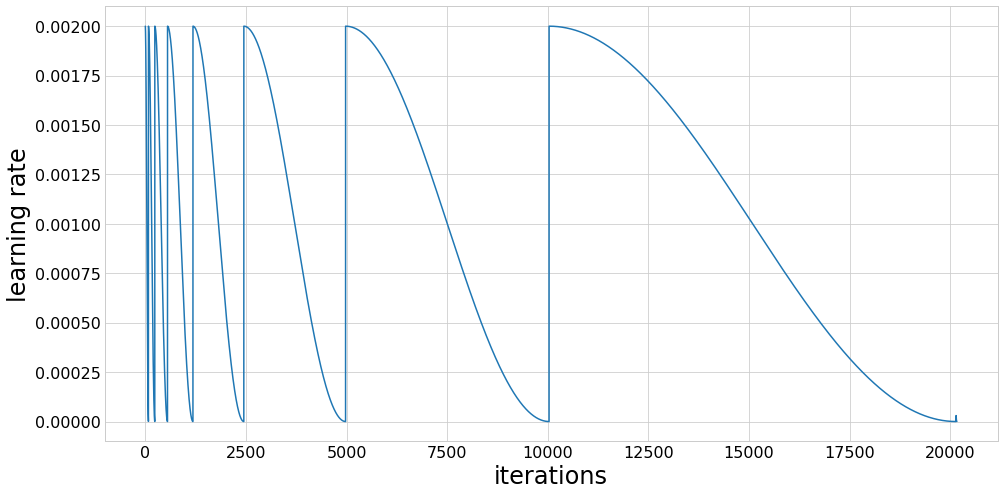

Fold took 314.859s


______________________________________
Training finished
Cross-validation took 3450.507s 


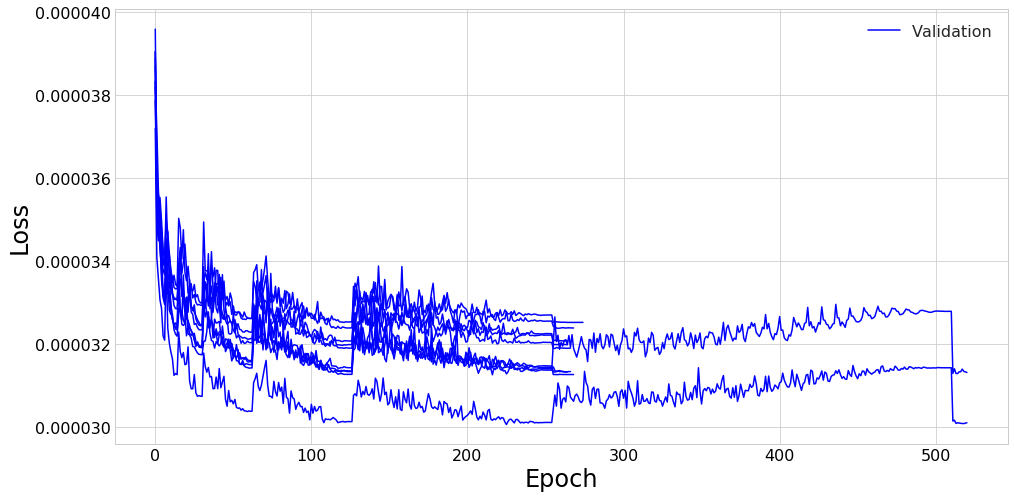

Mean loss = 3.16e-05 +- 2e-07
Mean wAUC = 0.0626 +- 0.0009
Mean AUC = 0.0976 +- 0.0007
Mean AMS = 4.1 +- 0.1
Mean cut = 0.966 +- 0.007
______________________________________



<Figure size 432x288 with 0 Axes>

In [16]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

The impact of data augmentation is pretty clear. Comparing the training here to that of the the CRL Swish model without augmentation we can see that we effectively gain another LR cycles worth of training epochs before we start overfitting, which allows the networks to reach much lower looses (3.18e-5 c.f. 3.23e-5) and a higher AMSs (3.98 c.f. 3.71)

## Construct ensemble

In [17]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [18]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 2 with loss = 3.0057381651687433e-05
Model 1 is 6 with loss = 3.125822596557555e-05
Model 2 is 4 with loss = 3.12618416530313e-05
Model 3 is 8 with loss = 3.1320558427250945e-05
Model 4 is 3 with loss = 3.13211458879562e-05
Model 5 is 1 with loss = 3.189260038493725e-05
Model 6 is 5 with loss = 3.196850994246895e-05
Model 7 is 7 with loss = 3.2061479044205044e-05
Model 8 is 0 with loss = 3.237742165836565e-05
Model 9 is 9 with loss = 3.252074927022325e-05


## Response on validation data without TTA

In [19]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [20]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0020340496085584163s per sample

Predicting fold 2 out of 10
Prediction took 0.0003500885963439941s per sample

Predicting fold 3 out of 10
Prediction took 0.00035382659062743185s per sample

Predicting fold 4 out of 10
Prediction took 0.00034765722528100015s per sample

Predicting fold 5 out of 10
Prediction took 0.0003507812924683094s per sample

Predicting fold 6 out of 10
Prediction took 0.00035837703943252566s per sample

Predicting fold 7 out of 10
Prediction took 0.00035142892152071s per sample

Predicting fold 8 out of 10
Prediction took 0.00034391293898224833s per sample

Predicting fold 9 out of 10
Prediction took 0.0003359652251005173s per sample

Predicting fold 10 out of 10
Prediction took 0.00034541122913360597s per sample



In [21]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9041970080784291, weighted 0.9363446295026197


In [22]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(4.028819039036499, 0.9662906)

In [23]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.1+-0.2, at mean cut of 0.965+-0.009
Exact mean cut 0.9649307781364769, corresponds to calc_ams of 3.900869108453573
CPU times: user 2.57 s, sys: 14.1 s, total: 16.7 s
Wall time: 2min 10s


(4.1, 0.965)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

## Response on validation data with TTA

In [24]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                             rotate=False, reflect_x=False, reflect_y=True, reflect_z=True,
                             input_pipe=input_pipe, rot_mult=0)

Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4


In [25]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0014380710005760192s per sample

Predicting fold 2 out of 10
Prediction took 0.0014268247485160828s per sample

Predicting fold 3 out of 10
Prediction took 0.0014148427881300449s per sample

Predicting fold 4 out of 10
Prediction took 0.0014331313334405421s per sample

Predicting fold 5 out of 10
Prediction took 0.0014340218402445317s per sample

Predicting fold 6 out of 10
Prediction took 0.0014311574175953864s per sample

Predicting fold 7 out of 10
Prediction took 0.0014684895314276219s per sample

Predicting fold 8 out of 10
Prediction took 0.0014263297088444233s per sample

Predicting fold 9 out of 10
Prediction took 0.0014086257629096508s per sample

Predicting fold 10 out of 10
Prediction took 0.001415598463267088s per sample



In [26]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9043125276842008, weighted 0.9364307889393174


In [27]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(4.000109465670075, 0.9664597)

In [28]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.964+-0.01
Exact mean cut 0.9638839482795447, corresponds to calc_ams of 3.917696290650801
CPU times: user 2.49 s, sys: 13.7 s, total: 16.2 s
Wall time: 2min 9s


(4.0, 0.964)

Adding test-time augmentation provides further benefits: overall AMS 3.90->3.97, AMS corresponding to mean cut 3.89->3.91.

# Test scoring - Without TTA

In [36]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [37]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0003472660998051817s per sample

Predicting fold 2 out of 10
Prediction took 0.0003486093290827491s per sample

Predicting fold 3 out of 10
Prediction took 0.00034742548397996207s per sample

Predicting fold 4 out of 10
Prediction took 0.00034568192660808564s per sample

Predicting fold 5 out of 10
Prediction took 0.00034847509651021524s per sample

Predicting fold 6 out of 10
Prediction took 0.0003493281391533938s per sample

Predicting fold 7 out of 10
Prediction took 0.0003550174436785958s per sample

Predicting fold 8 out of 10
Prediction took 0.0003531472758813338s per sample

Predicting fold 9 out of 10
Prediction took 0.0003432174590500918s per sample

Predicting fold 10 out of 10
Prediction took 0.0003428094150667841s per sample

CPU times: user 3min 25s, sys: 16.8 s, total: 3min 42s
Wall time: 3min 11s


In [38]:
score_test_data(test_fy.source, 0.9649307781364769)

Public:Private AMS: 3.6032694609356026 : 3.7362958619491824


(3.6032694609356026, 3.7362958619491824)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Test scoring - With TTA

In [31]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                             rotate=False, reflect_x=False, reflect_y=True, reflect_z=True,
                             input_pipe=input_pipe, rot_mult=0)

Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4


In [32]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0014065027402205901s per sample

Predicting fold 2 out of 10
Prediction took 0.0014199681802906773s per sample

Predicting fold 3 out of 10
Prediction took 0.0014034707727080041s per sample

Predicting fold 4 out of 10
Prediction took 0.0013967939151958986s per sample

Predicting fold 5 out of 10
Prediction took 0.0013746820844709874s per sample

Predicting fold 6 out of 10
Prediction took 0.0013859566003084182s per sample

Predicting fold 7 out of 10
Prediction took 0.0013777138034051116s per sample

Predicting fold 8 out of 10
Prediction took 0.0013849634320221163s per sample

Predicting fold 9 out of 10
Prediction took 0.0014121298053047873s per sample

Predicting fold 10 out of 10
Prediction took 0.001392164763130925s per sample

CPU times: user 13min 39s, sys: 1min 23s, total: 15min 3s
Wall time: 12min 47s


In [35]:
score_test_data(test_fy.source, 0.9638839482795447)

Public:Private AMS: 3.597300626669451 : 3.751274233092376


(3.597300626669451, 3.751274233092376)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)